# IEOR 243 Group 10 Demo

#### Target Audience and Primary Objective


Suppose we are a data analytics service provider for the Centers for Disease Control and Prevention (CDC) or some other public health organization. 

Our client's primary objective is to <u>gain insight into public sentiment, misinformation, and key topics of discussion surrounding COVID-19</u>, which will help them tailor communication strategies and public health campaigns more effectively.

**Assumptions**: 

Our main point of contact at the organization has some analytics skills (reading plots, basic statistics, etc), but is not an expert in machine learning.


#### High-Level Model Summary

Our modeling approach has four main steps to it:

1) Convert all the tweet text to numbers representing the different words/tokens. These are called <u>word embeddings</u>
    
2) Use a <u>clustering model</u> to group the tweets together into 8 different categories, based on the content of the tweet.

3) Use a version of ChatGPT to sample 50-100 tweets from each cluster and describe the tweet using 5-10 keywords
- Now, we have a list of 40 labels
4) Train a <u>Multioutput</u> classification model to assign labels to each tweet in our dataset.
- We trained many types: logistic regression, linear discriminant analysis, multilayer perceptrons, random forests, gradient boosting, etc
    

#### High-Level Metric Summary

The primary metric we use to score models is the <u>Hamming Loss</u>, which the proportion of labels that are *incorrectly* assigned. For instance, a score of 0.05 means 95% of labels were correctly identified (similar to accuracy).

We selected the models with the lowest hamming loss.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from typing import Union, List, Callable
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output
import re

import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer

## Part 1: Interactive EDA

Before using any machine learning, it's often helpful to run ad hoc exploratory data analysis to get a general sense of the data. We want to give the CDC the ability to get macro-trends from the tweet data for the following concepts. 

1) Most common words in tweets 
2) Length of tweets
3) Number of tweets

**Client Choice**: Because COVID-19 was a global pandemic, it's important to give our client the choice of where to focus their future analysis.

For instance, if we see different trends in different locations at different times, this can advice the CDC to aim their messaging differently to different locations.

Everything plot type can be filtered by **Date Range** and **Location**

##### Examples

- Visualize how many #COVID19 tweets are coming from the United States vs other countries


- What are the most common words being used in tweets in the United States in March 2020? 
    - What about August 2020?

In [2]:
# Preprocessing Helper Functions
def preprocess_text(text: str) -> str:
    
    """
    Processes a tweet string by removing any weird string characters/formattings
    Args: 
        - text (str): the text to clean
    Returns: 
        - clean_text (str): the cleaned text string
    """
    # convert to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r"http\S+", "", text)

    # Removing Emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Removing emoticons
    text = re.sub(r':\w+:', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Removing Contractions
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    clean_text = text
    
    return clean_text

def preprocess_nulls(df: pd.DataFrame) -> pd.DataFrame: 
    
    """
    Removes nulls and 0 counts from a dataframe
    Args: 
        - df (pd.DataFrame): the dataframe to remove nulls from
    Returns: 
        - clean_df (str): the cleaned df
    """
    
    # Drop duplicate rows 
    df = df.drop_duplicates(subset = "text")
    
    # Drop rows with no followers 
    df = df[df['user_followers'] > 0]
    
    # Drop nulls and reset index 
    df = df.dropna().reset_index(drop = True)
    
    clean_df = df
    
    return clean_df

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Main processing function on the dataframe
    Args: 
        - df (pd.DataFrame): df of tweets to process
    Returns: 
        - preprocessed_df (pd.DataFrame): the processed df
    """
    
    # Preprocess null and missing values 
    df = preprocess_nulls(df)
    
    # Preprocess text 
    df['processed_text'] = df['text'].apply(preprocess_text)            
    
    return df


def create_widget(): 
    
    """
    Creates the widget options and returns them
    """
    
    # Dropdown menu to choose the plot
    plot_options = ['Bar Plot of Most Common Words in Tweets', 'Distribution of Length of Tweets', 'Time-series Plot of Tweet Counts', 'Word Cloud of Most Common Words']
    plot_dropdown = widgets.Dropdown(
        options=plot_options,
        value=plot_options[0],
        description='Select Plot:',
    )

    # Dropdown menu to choose the country
    country_options = ['All Countries', 'United States', 'Canada', 'South Africa','Switzerland','London','India','United Kingdom']
    country_dropdown = widgets.Dropdown(
        options=country_options,
        value=country_options[0],
        description='Country:',
    )

    # Date range picker
    start_date_picker = widgets.DatePicker(
        description='Start Date',
        disabled=False
    )

    end_date_picker = widgets.DatePicker(
        description='End Date',
        disabled=False
    )


    # Button to process the dataset and generate the plot
    process_button = widgets.Button(
        description='Plot',
        tooltip='Plot',
    )

    # Output widget to display the result
    output = widgets.Output()
    
    
    return plot_dropdown, country_dropdown, start_date_picker, end_date_picker, process_button, output

def load_process_data(file_path): 
    
    """
    Loads data and logs if successful"""
    
    try: 
        df = pd.read_csv(file_path)
    except: 
        print('Could not load data')
        return

    # Convert to date
    df['date'] = pd.to_datetime(df['date']).dt.date


    # Log the output
    min_date = df['date'].min().strftime('%m/%d/%Y')
    max_date = df['date'].max().strftime('%m/%d/%Y')
    print("\nData is loaded successfully")
    print(f'   Earliest Tweet Date: {min_date}')
    print(f'   Latest Tweet Date: {max_date}')


    # Preprocess dataset
    preprocessed_df = preprocess_df(df)
    print("\nYour data is ready for analysis.")
    
    return preprocessed_df

def filter_df(preprocessed_df, country_dropdown, start_date_picker, end_date_picker): 
    
    """
    Filters the DF based on rules from the dropdowns and option widgets
    """
    
    # Filter tweets by country
    selected_country = country_dropdown.value
    if selected_country != 'All Countries':
        filtered_df = preprocessed_df.loc[preprocessed_df['user_location'] == selected_country]
    else:
        filtered_df = preprocessed_df


    filtered_df['date'] = pd.to_datetime(filtered_df['date'])

    start_date = start_date_picker.value
    end_date = end_date_picker.value
    if start_date and end_date:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]
        
    return filtered_df

In [3]:
# Plotting Helper Functions
def generate_bar_plot(filtered_df): 
    
    """
    Bar plot
    """
    # code for bar plot
    text = " ".join(filtered_df['processed_text'])
    words = text.split()
    words_counter = Counter(words)
    most_common_words = words_counter.most_common(20)

    words = [word[0] for word in most_common_words]
    counts = [word[1] for word in most_common_words]

    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Bar Plot of Most Common Words in Tweets')
    plt.xticks(rotation=90)
    plt.show()

def generate_tweet_length_plot(filtered_df): 
    
    # code for length distribution plot
    filtered_df['text_length'] = filtered_df['text'].apply(len)
    filtered_df['text_length'].plot.hist(bins=30, rwidth=0.9)
    plt.xlabel('Length of Tweets')
    plt.ylabel('Counts')
    plt.title('Distribution of Length of Tweets')
    plt.show()

def generate_time_series_plot(filtered_df): 
    # code for time-series plot
        filtered_df['date'] = pd.to_datetime(filtered_df['date'])
        df_grouped = filtered_df.groupby(filtered_df['date'].dt.date).count()
        fig, ax = plt.subplots()
        ax.plot(df_grouped.index, df_grouped['text'])
        ax.set_ylabel('Number of Tweets')
        ax.set_title('Time-series Plot of Tweet Counts')
        plt.xticks(rotation=90)
        plt.show()

def generate_word_cloud(filtered_df): 
    
    # code for word cloud
        text = " ".join(filtered_df['processed_text'])
        words = text.split()
        words_counter = Counter(words)
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words_counter)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title('Word Cloud of Most Common Words')
        plt.show()

def generate_word_cloud_by_location(filtered_df): 
    
    top_words_by_location = {}
    for location in filtered_df['user_location'].unique():
        location_df = filtered_df.loc[filtered_df['user_location'] == location]
        text = " ".join(location_df['processed_text'])
        words = text.split()
        words_counter = Counter(words)
        most_common_words = words_counter.most_common(20)
        top_words_by_location[location] = most_common_words
        
        
     # Plot word cloud for each location
    for location, top_words in top_words_by_location.items():
        words = [word[0] for word in top_words]
        frequencies = [word[1] for word in top_words]
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(zip(words, frequencies)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Most Common Words in Tweets from {location}')
        plt.show()

In [5]:
# Demo


# Load and process data
file_path = input("Please enter the path to your CSV file: ")
preprocessed_df = load_process_data(file_path)

if preprocessed_df is not None:

    # Create the widget
    plot_dropdown, country_dropdown, start_date_picker, end_date_picker, process_button, output = create_widget()


    def on_button_click(b):
        with output:
            output.clear_output()

            # Filter DF based on dropdown / options 
            filtered_df = filter_df(preprocessed_df, country_dropdown, start_date_picker, end_date_picker)

            # Plot selected graph
            selected_plot = plot_dropdown.value

            if selected_plot == 'Bar Plot of Most Common Words in Tweets':
                generate_bar_plot(filtered_df)
            elif selected_plot == 'Distribution of Length of Tweets':
                generate_tweet_length_plot(filtered_df)
            elif selected_plot == 'Time-series Plot of Tweet Counts':
                generate_time_series_plot(filtered_df)
            elif selected_plot == 'Word Cloud of Most Common Words':
                generate_word_cloud(filtered_df)
            else: # 'Word Cloud of Most Common Words by Location'
                generate_word_cloud_by_location(filtered_df)


    process_button.on_click(on_button_click)

    #Display widgets

    display(country_dropdown)
    display(start_date_picker)
    display(end_date_picker)
    display(plot_dropdown)
    display(process_button)
    display(output)

Please enter the path to your CSV file: ../data/covid2020.csv

Data is loaded successfully
   Earliest Tweet Date: 07/24/2020
   Latest Tweet Date: 08/30/2020

Your data is ready for analysis.


Dropdown(description='Country:', options=('All Countries', 'United States', 'Canada', 'South Africa', 'Switzer…

DatePicker(value=None, description='Start Date', step=1)

DatePicker(value=None, description='End Date', step=1)

Dropdown(description='Select Plot:', options=('Bar Plot of Most Common Words in Tweets', 'Distribution of Leng…

Button(description='Plot', style=ButtonStyle(), tooltip='Plot')

Output()

## Part 2: Real Time Inference

After analysis has been done, it's important to let our clients use the models for more recent data. This project took a few months, and many more #COVID19 tweets have been created since then, with new protocols, vaccine information, regulation, etc.

**Client Choice**: We want to give the ability to the health organization to see trends in individual tweets.

**Client Choice**: More importantly, the organization needs to be given the ability to choose which model they want. Even though there is similar performance between the best two models, they can give slightly different results. The analysts at the organization should be able to choose ad hoc.

#### Sample Tweets to try:

- #COVID19 cases are on the rise again. Let's all do our part to stop the spread: get vaccinated, wear a mask, and social distance. Together, we can beat this virus.
- Indian municipalities have been a great failure in controlling #COVID19 , barring a few.
- Coronavirus infections top half a million in South Africa... #SouthAfrica #Gauteng #Pretoria #COVID

In [6]:
# Load in necessary data 

# Load in embedding model 
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Load in trained models 
lr = pickle.load(open('../trained_models/lr_v2.pkl', 'rb'))
lda = pickle.load(open('../trained_models/lda_v2.pkl', 'rb'))
kmeans = pickle.load(open('../trained_models/kmeans.pkl', 'rb'))

# Grab the labels from GPT API from Module 2
labels_dict = {
    0: ['social issues', 'personal development', 'business and economics', 'community building'],
    1: ['india', 'updates', 'testing', 'fatalities', 'recoveries', 'healthcare'],
    2: ['face masks', 'safety', 'protection', 'public health', 'prevention'],
    3: ['social media', 'resilience', 'community support', 'online events'],
    4: ['global', 'cases', 'deaths', 'statistics'],
    5: ['politics', 'government response', 'public health', 'conspiracy', 'human rights'],
    6: ['health', 'information','vacccine', 'public awareness'],
    7: ['layoffs', 'misinofrmation', 'mental health', 'lockdown', 'access', 'financial impact', 'political response', 'education']
}

# Grab the labels from GPT API from Module 2
labels = ['social-issues',
 'personal-development',
 'business-and-economics',
 'community-building',
 'india',
 'updates',
 'testing',
 'fatalities',
 'recoveries',
 'healthcare',
 'face-masks',
 'safety',
 'protection',
 'public-health',
 'prevention',
 'social-media',
 'resilience',
 'community-support',
 'online-events',
 'global',
 'cases',
 'deaths',
 'statistics',
 'politics',
 'government-response',
 'conspiracy',
 'human-rights',
 'health',2
 'information',
 'vacccine',
 'public-awareness',
 'layoffs',
 'misinformation',
 'mental-health',
 'lockdown',
 'access',
 'financial-impact',
 'political-response',
 'education']

def make_prediction(tweet: str, 
                    labels: Union[dict, list],
                    embedding_model: SentenceTransformer, 
                    classification_model = None,
                    clustering_model = None): 
    
    """
    Generate a list of predicted labels for an input tweet
    """
    
    # Generate the word embedding 
    embedding = embedding_model.encode(tweet)
    embedding = embedding.reshape(1, -1).astype(float)
    
    # If both there -> return nothing because error
    if (clustering_model) and (classification_model):
        return None
    
    # If clustering -> use that
    if (clustering_model):
        prediction = clustering_model.predict(embedding)
        return labels[prediction[0]]
    
    if (classification_model):
        prediction = classification_model.predict(embedding)[0]
        return [labels[i] for i in range(len(labels)) if prediction[i] == 1]

In [7]:
# Demo

# Tweet Input
tweet = input("Enter a tweet: ")

# Select model type 
options = ['KMeans + GPT API', 'Logistic Regression', 'Linear Discriminant Analysis']
dropdown = widgets.Dropdown(options = options,
                            value = options[1],
                            description = 'Select Model Type: ')

# Button to process the dataset and generate the plot
button = widgets.Button(description = 'Run Inference', tooltip = 'Run Inference')

# Display Result
output = widgets.Output()

def run_inference(labels, labels_dict, embedding_model, kmeans, lr, lda, verbose = True): 
    
    with output: 
        
        # Clear any existing display
        output.clear_output()
    
        # If clustering
        if dropdown.value == options[0]: 
            labels = make_prediction(tweet = tweet, 
                                     labels = labels_dict, 
                                     embedding_model = embedding_model,
                                     clustering_model = kmeans, 
                                     classification_model = None)
        elif dropdown.value == options[1]: 
            labels = make_prediction(tweet = tweet, 
                                     labels = labels_dict, 
                                     embedding_model = embedding_model,
                                     clustering_model = None, 
                                     classification_model = lr)
            
        else:
            labels = make_prediction(tweet = tweet, 
                                     labels = labels,
                                     embedding_model = embedding_model,
                                     clustering_model = None, 
                                     classification_model = lda)
            
        # Print output
        if verbose: 
            print(labels)
            
        return labels

button.on_click(lambda _: run_inference(labels, labels_dict, embedding_model, kmeans, lr, lda))

# Display everything 
display(dropdown)
display(button)
display(output)

Enter a tweet: 


Dropdown(description='Select Model Type: ', index=1, options=('KMeans + GPT API', 'Logistic Regression', 'Line…

Button(description='Run Inference', style=ButtonStyle(), tooltip='Run Inference')

Output()

## Part 2 (Extended):

Let's take this one step further. To better understand the discussions surrounding COVID-19>>>>>>>
FILL THIS IN

Example Users: 
- Shankar Prasad (Minister of Electronics and Information Technology)

Username: Shankar Prasad


Dropdown(description='Model: ', index=1, options=('KMeans + GPT API', 'Logistic Regression', 'Linear Discrimin…

Button(description='Run Inference', style=ButtonStyle(), tooltip='Run Inference')

Output()

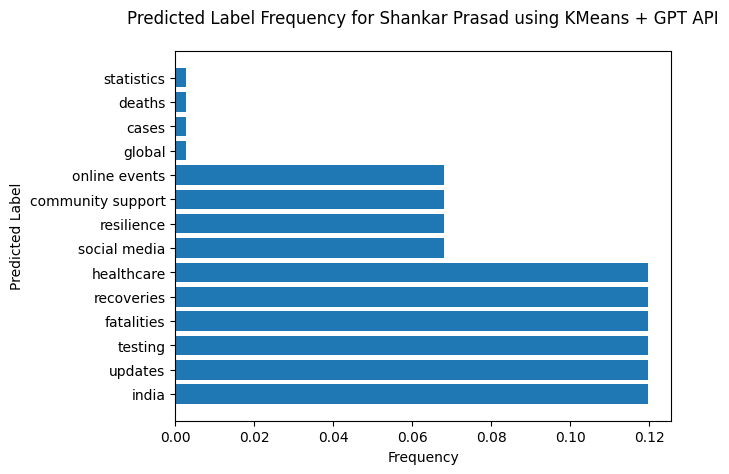

In [19]:
# Demo

# Tweet Input
username = input("Username: ")

# Select model type 
options = ['KMeans + GPT API', 'Logistic Regression', 'Linear Discriminant Analysis']
dropdown = widgets.Dropdown(options = options,
                            value = options[1],
                            description = 'Model: ')

# Button to process the dataset and generate the plot
button = widgets.Button(description = 'Run Inference', tooltip = 'Run Inference')

# Display Result
output = widgets.Output()

def run_inference(preprocessed_df, labels, labels_dict, embedding_model, kmeans, lr, lda, verbose = True): 
    
    with output: 
        
        # Clear any existing display
        output.clear_output()
        
        # User tweets
        user_df = preprocessed_df[preprocessed_df['user_name'] == username]
        if len(user_df) > 0:
            n_tweets = len(user_df)
            user_tweets = user_df.sample(n_tweets)['text']
            
            vals = []
            for tweet in user_tweets: 
                if dropdown.value == options[0]: 
                    labels = make_prediction(tweet = tweet, 
                                             labels = labels_dict, 
                                             embedding_model = embedding_model,
                                             clustering_model = kmeans, 
                                             classification_model = None)
                    vals += labels
                elif dropdown.value == options[1]: 
                    labels = make_prediction(tweet = tweet, 
                                             labels = labels, 
                                             embedding_model = embedding_model,
                                             clustering_model = None, 
                                             classification_model = lr)
                elif dropdown.value == options[2]: 
                    labels = make_prediction(tweet = tweet, 
                                             labels = labels, 
                                             embedding_model = embedding_model,
                                             clustering_model = None, 
                                             classification_model = lda)
                    vals += labels
            
            
            d = pd.Series(vals).value_counts(normalize = True)
            print(d)
            plt.barh(d.index, d.values)
            plt.xlabel('Frequency')
            plt.ylabel('Predicted Label')
            plt.title(f'Predicted Label Frequency for {username} using {dropdown.value}', pad = 20)

button.on_click(lambda _: run_inference(preprocessed_df, labels, labels_dict, embedding_model, kmeans, lr, lda))

# Display everything 
display(dropdown)
display(button)
display(output)